# Pytorch with the MNIST Dataset - MINST

In [11]:
!pip install torch torchvision 

  Using cached torch-2.2.2-cp312-none-macosx_10_9_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.17.2-cp312-cp312-macosx_10_13_x86_64.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 31.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.8 MB/s eta 0:00:00


In [13]:
## import libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [14]:
print(torch.__version__)

2.2.2


In [17]:
args={}
kwargs={}
args['batch_size']=32
args['test_batch_size']=32
args['epochs']=1  #The number of Epochs is the number of times you go through the full dataset.
args['lr']=0.01 #Learning rate is how fast it will decend.
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True #if the computer has a GPU, type True, otherwise, False

This code is adopted from the pytorch examples repository. It is licensed under BSD 3-Clause "New" or "Revised" License. Source: https://github.com/pytorch/examples/ LICENSE: https://github.com/pytorch/examples/blob/master/LICENSE

## Load Dataset
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning.

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models.
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [19]:
## transformations
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

## download and load training dataset
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True, **kwargs)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 12265571.18it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 1487879.31it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 7324107.87it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2059739.30it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 5322708.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 1366818.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 9029698.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 3279485.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order.

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


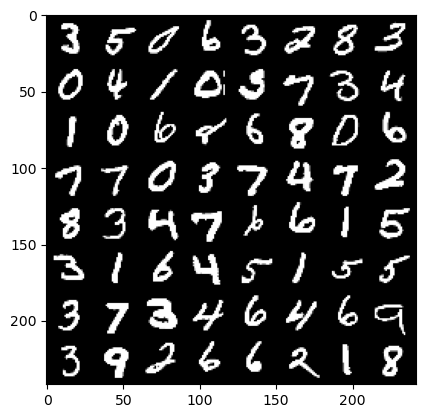

In [207]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [209]:
for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## The Model
We provide two fully-connected neural net as the initial architecture.

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have two fully-connected netork network. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`.

- After the first layer, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [25]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x=x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


**Now, add one CNN layer with a pooling to the above neural network and rerun the code to see whether you get higher prediction accuracy on the test set.**

For example, you may try `out_channels=32`. Kernel size is 5, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d).

- In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer.

Make sure your flatten the output of CNN layer excluding # of batch so that the input of each example/batch has the same size of the first neural net.

Tips: You can use x.view(-1, # of input size of the first fully-connected layer) or you can use torch.flatten(x, 1).

I always encourage to test the model with 1 batch to ensure that the output dimensions are what we expect.

In [211]:
# after 1 CNN layer + Pooling before the FC layer
class NetWithCNN(nn.Module):
    def __init__(self):
        super(NetWithCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  # out: (10, 24, 24)
        self.pool = nn.MaxPool2d(2, 2)                # out: (10, 12, 12)
        self.fc1 = nn.Linear(10 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 10 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [225]:
# Experiment 1 - More CNN layer + More FC layer
class NetExp1(nn.Module):
    def __init__(self):
        super(NetExp1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)     # 28x28 → 28x28
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)    # 28x28 → 28x28
        self.pool = nn.MaxPool2d(2, 2)                  # 28x28 → 14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [213]:
## test the model with 1 batch
model = NetWithCNN()
#print(model)
for images, labels in train_loader:
    print("batch size:", args['batch_size'])
    out = model(images)
    print(out.shape)
    break

batch size: 32
torch.Size([64, 10])


In [175]:
# Define different batch sizes to experiment with
batch_sizes = [16, 32, 64]

# Loop over each batch size
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    # Update the batch size in the data loaders
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, **kwargs
    )


Training with batch size: 16

Training with batch size: 32

Training with batch size: 64


## Training the Model
Now we are ready to train the model.

In [227]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically.
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [229]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          data, target = Variable(data), Variable(target)
          output = model(data)
          test_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [231]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NetExp1().to(device)

optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])

#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303303
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.289169
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266517
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.225656
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.173519
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.967086
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.716753
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.034397
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.652172
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.710988
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.419565
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.632586
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.518591
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.420199
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.876131
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.466562
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.478243
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.496200
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.315062
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.461711
Train Epoch: 1 [12800/60000 (

In [183]:
# Define different batch sizes to experiment with
batch_sizes = [16, 32, 64]

# Loop over each batch size
for batch_size in batch_sizes:
    print(f"\n=== Training with Batch Size = {batch_size} ===")

    # Update the batch size in the data loaders
    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, **kwargs
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, **kwargs
    )

    # Initialize model and optimizer for each batch size
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NetWithCNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Train and test for each batch size
    for epoch in range(1, args['epochs'] + 1):
        train(epoch)  # Uses the current train_loader (with correct batch_size)
        test()        # Uses the current test_loader (with correct batch_size)


=== Training with Batch Size = 16 ===
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286253
Train Epoch: 1 [160/60000 (0%)]	Loss: 1.780592
Train Epoch: 1 [320/60000 (1%)]	Loss: 1.018303
Train Epoch: 1 [480/60000 (1%)]	Loss: 0.625449
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.836220
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.917405
Train Epoch: 1 [960/60000 (2%)]	Loss: 0.593274
Train Epoch: 1 [1120/60000 (2%)]	Loss: 0.215821
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.748352
Train Epoch: 1 [1440/60000 (2%)]	Loss: 0.182644
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.788879
Train Epoch: 1 [1760/60000 (3%)]	Loss: 0.503992
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.300241
Train Epoch: 1 [2080/60000 (3%)]	Loss: 0.491140
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.425618
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.126837
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.123267
Train Epoch: 1 [2720/60000 (5%)]	Loss: 0.402130
Train Epoch: 1 [2880/60000 (5%)]	Loss: 0.524026
Train Epoch: 1 [3040/60000 (5%)]	Loss: 0.839281
Train Epoc